# INTRODUCTION

This notebook looks into developing an end-to-end machine learning pipeline in Python to predict the probability of default (Credit risk modelling concept) using a financial dataset.

We're going to take the following approach:

- Problem definition
- Data
- Evaluation
- Features
- Modelling
- Experimentation

### Problem Definition

- Given Financial details about a person, can we predict whether or not they are likely to default on a loan?

### Evaluation

- If we can reach a considerable good roc-auc score in classification.


# Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.


In [171]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve




### Load Data


In [172]:
 
data = pd.read_csv('data_science_competition_2024.csv')
df = pd.read_csv('data_science_competition_2024.csv')
df.columns
print(df.shape )# (rows, columns)
df.head(4)


(100000, 21)


,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,...,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,...,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,...,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,...,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,...,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default


#### class balance


# PRIMARY DATA CLEANING


### Feature data type correction


In [173]:
df.dtypes

Unnamed: 0                int64
loan_id                  object
gender                   object
disbursemet_date         object
currency                 object
country                  object
sex                      object
is_employed                bool
job                      object
location                 object
loan_amount             float64
number_of_defaults        int64
outstanding_balance     float64
interest_rate           float64
age                       int64
number_of_defaults.1      int64
remaining term           object
salary                  float64
marital_status           object
age.1                     int64
Loan Status              object
dtype: object

In [174]:
# function to correct spelling
def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel



In [175]:
#Convert remaining term feature to consitenly become numeric

# Convert to string to handle non-numeric characters
df['remaining term'] = df['remaining term'].astype(str)

# Remove underscores and extra spaces
df['remaining term'] = df['remaining term'].str.replace('_', '').str.strip()

# Convert back to numeric if all values are intended to be numeric
df['remaining term'] = pd.to_numeric(df['remaining term'], errors='coerce')


df['remaining term'].dtype

dtype('int64')

## Feature category spelling correction


In [176]:
print(df['location'].value_counts())
#incorrect spellings for locations


location
Harare               8338
Bulawayo             8078
Mutare               8062
Gweru                7803
Masvingo             7476
                     ... 
 Redcliff               1
Victoria Falls          1
Victoria Falls          1
   Gokwe                1
Gokwe                   1
Name: count, Length: 157, dtype: int64


In [177]:
#location feature textual normalization
df['location'] = df['location'].str.strip()

# convert lowercase
df['location'] = df['location'].str.lower()

# Create a dictionary to map incorrect variations to correct values
mapping = {
    'harare': 'Harare',
    'bulawayo': 'Bulawayo',
    'mutare': 'Mutare',
    'gweru': 'Gweru',
    'masvingo': 'Masvingo',
    'marondera': 'Marondera',
    'rusape': 'Rusape',
    'chivhu': 'Chivhu',
    'plumtree': 'Plumtree',
    'beitbridge': 'Beitbridge',
    'chipinge': 'Chipinge',
    'chimanimani': 'Chimanimani',
    'kwekwe': 'Kwekwe',
    'chiredzi': 'Chiredzi',
    'kadoma': 'Kadoma',
    'nyanga': 'Nyanga',
    'karoi': 'Karoi',
    'shurugwi': 'Shurugwi',
    'zvishavane': 'Zvishavane',
    'gokwe': 'Gokwe',
    'kariba': 'Kariba',
    'victoria falls': 'Victoria Falls',
    'redcliff': 'Redcliff',
    'hwange': 'Hwange'
}

# Replace incorrect values using the mapping dictionary
df['location'] = df['location'].replace(mapping)



print(df['location'].value_counts())
# the locations are now normalized


location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64


In [178]:
print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())
#Textual normalization required

df['Category'] = df['location'].apply(lambda x: 
                                     
                                     2 if x in [
    
    'Karoi',
    'Hwange',
     'Chiredzi',
    'Gokwe',
    
   
    'Shurugwi',
    'Victoria Falls',
    
    ] else 0 if x in ['Nyanga', 'Chivhu', 'Kadoma', 'Marondera', 'Gweru', 'Masvingo', 'Harare', 'Bulawayo', 'Mutare'] else 1 )

currency
USD     99980
$USD       20
Name: count, dtype: int64

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64


In [179]:
#correcting feature categories

def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel
    return df.loc[:, column].value_counts()

consistent_column_spelling('currency', '$USD', 'USD')
consistent_column_spelling('job', 'Data Scintist', 'Data Scientist')
consistent_column_spelling('job', 'SoftwareDeveloper', 'Software Developer')
consistent_column_spelling('country', 'Zimbabwe', 'zimbabwe')
consistent_column_spelling('country', 'Zim', 'zimbabwe')

print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())

currency
USD    100000
Name: count, dtype: int64

country
zimbabwe    99900
Name: count, dtype: int64

job
Engineer              16524
Software Developer    15496
Nurse                 15284
Data Analyst          13204
Doctor                12186
Teacher                8950
Accountant             7802
Data Scientist         3556
Lawyer                 2862
Name: count, dtype: int64


Drop unnecessary and redundant columns


In [180]:


# Drop unnecessary columns
df.drop(['loan_id', 'Unnamed: 0', 'age.1', 'number_of_defaults.1', 'sex'], axis=1, inplace=True)



# EXPLORATORY DATA ANALYSIS

#### The goal here is to find out more about the data and become a subject matter expert.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?


In [181]:
df.describe()

,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,Category
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,31120.000000,0.441970,36964.909763,0.210435,43.57069,52.881870,2781.804324,0.477270
std,15895.093631,0.688286,10014.758477,0.018725,4.86376,11.985833,696.450055,0.634214
min,1000.000000,0.000000,0.000000,0.100000,21.00000,0.000000,250.000000,0.000000
25%,21000.000000,0.000000,29625.227472,0.200000,40.00000,45.000000,2273.929349,0.000000
50%,31000.000000,0.000000,35063.852394,0.210000,44.00000,52.000000,2665.441567,0.000000
75%,40000.000000,1.000000,42133.388817,0.220000,47.00000,61.000000,3146.577655,1.000000
max,273000.000000,2.000000,150960.000000,0.300000,65.00000,120.000000,10000.000000,2.000000


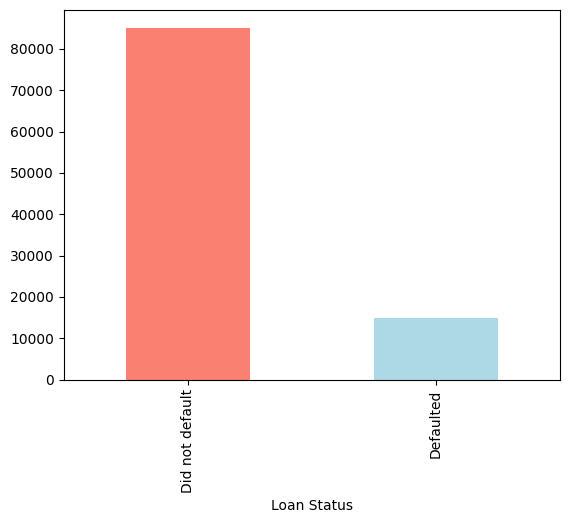

In [182]:

df['Loan Status'].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [183]:
print(df.shape)
print()
print(df.isna().sum())



(100000, 17)

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64


## Structure overview

- The dataset is has 100000 rows and 21 columns.
- It has both categorical and numerical features.
- It is extremely imbalanced
- It has missing values in the job, location and country columns


### Univariate relationships

- identify the distribution of the individual features


In [184]:
#univariate hist plots
# fig, (ax,ax1) = plt.subplots(2,3,figsize=(20,8))
# plt.suptitle('DISTRIBUTION PLOTS')
# sns.histplot(df,x= 'age', bins=100,kde=True, ax=ax[0], color='darkcyan');
# sns.histplot(df,x = 'interest_rate', bins=100,kde=True, ax=ax[1], color='salmon');
# sns.histplot(df, x = 'salary', bins=100,kde=True, ax=ax[2], color='darkviolet');
# sns.histplot(df, x = 'outstanding_balance', bins=100,kde=True, ax=ax1[0], color='yellow');
# sns.histplot(df, x = 'remaining term', bins=100,kde=True, ax=ax1[1], color='gold');
# sns.histplot(df, x = 'loan_amount', bins=100,kde=True, ax=ax1[2], color='darkgoldenrod');

# fig, ax = plt.subplots(1,4,figsize=(20,5))
# plt.suptitle('BOX PLOTS')
# sns.boxplot(df, x='loan_amount', ax=ax[0]);
# sns.boxplot(df, x='age', ax=ax[1]);
# sns.boxplot(df, x='outstanding_balance', ax=ax[2]);
# sns.boxplot(df, x='salary', ax=ax[3]);


#### OBSERVATIONS

- age, interest rate are uniformly distributed.
- outstanding balance, loan amount, salary and outstanding balance are skewed.
- Loan amount has a sharp peak at the start.
- outstanding balance and salary have considerable outliers.


#### Further investigate the sharp peak on loan amount distribution


In [185]:
# pd.set_option('display.max_colwidth', None)
# # print(df['remaining term'].value_counts().to_string())
# df[['loan_amount', 'outstanding_balance', 'remaining term', 'salary', 'age', 'interest_rate']].groupby((pd.cut(df['remaining term'], bins=np.arange(0, 150, 10)))).size()

In [186]:
# plt.figure(figsize=(10, 6))
# sns.histplot(df[df['loan_amount']<100000]['loan_amount'], kde=True)
# plt.title('Distribution of Loan Amounts below 10000')
# plt.show()

- There is indeed a sharp peak at around $5000. Indicates a high number of points there.


### TEST IF THE THESE NUMERICAL FEATURES ARE NORMALLY DISTRIBUTED USING QQPLOT


In [187]:
# import statsmodels.graphics.gofplots as sm

# plt.figure(figsize = (20,16))

# fig, ((ax, ax1), (ax2,ax3), (ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize = (15,12))
       
# sm.qqplot(df['interest_rate'], line='s', ax=ax)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax.set_ylabel('interest rates Quantiles')

# sm.qqplot(df['salary'], line='s', ax=ax1)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax1.set_ylabel('salary Quantiles')

# sm.qqplot(df['age'], line='s', ax=ax2)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax2.set_ylabel('age Quantiles')

# sm.qqplot(df['loan_amount'], line='s', ax=ax3)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax3.set_ylabel('loan amount Quantiles')

# sm.qqplot(df['remaining term'], line='s', ax=ax4)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax4.set_ylabel('remaining term Quantiles')
# sm.qqplot(df['outstanding_balance'], line='s', ax=ax5)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax5.set_ylabel('outstanding balance Quantiles')
       

LOAN AMOUNT AND SALARY AND OUTSTANDING BALANCE ARE HIGHLY DEVIATING AWAY FROM NORMAL DISTRIBUTION


## CATEGORICAL FEATURE DISTRIBUTION


## bivariate relationships


In [188]:
# fig, (ax, ax1, ax2) = plt.subplots(3,2,figsize=(15,18))

# sns.countplot(df,x= 'gender', ax=ax[0], palette='magma', hue='Loan Status');
# sns.countplot(df,x= 'marital_status', ax=ax[1], palette='spring', hue='Loan Status');
# sns.countplot(df,x= 'number_of_defaults', ax=ax1[0], palette='rocket', hue='Loan Status');
# sns.countplot(df,x= 'job', ax=ax1[1], palette='crest', hue='Loan Status');
# sns.countplot(df,x= 'location', ax=ax2[0], palette='mako', hue='Loan Status', );
# sns.countplot(df,x= 'is_employed', ax=ax2[1], palette='cividis', hue='Loan Status', );
# ax2[0].set_xticks(ax2[0].get_xticks());
# ax1[1].set_xticks(ax1[1].get_xticks());
# ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=45, ha='right');
# ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45, ha='right');
# plt.subplots_adjust(hspace=0.4)

### OBSERVATIONS

- Towns like Chiredzi, Shurugwi, Gokwe, Karoi, Hwange and Kwekwe have high probability of defaulting
- Cities like Harare, Bulawayo, 'Mutare', 'Gweru have low probability of Default'
- People who are married are less likely to deafulted
- People with less previous defaults are less likely to deasex is roughly balanced
- There is an additional unlabeled marital status category
- Lawyers and Accountants have high probability of defaulting


In [189]:

# # Create another figure
# plt.figure(figsize=(10, 6))
# fig, ((ax, ax1), (ax2,ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (15,12))

# sns.scatterplot(data=df, x='age', y= 'interest_rate', hue= 'Loan Status', ax= ax);
# sns.scatterplot(data=df, x='age', y= 'loan_amount', hue= 'Loan Status', ax= ax1);
# sns.scatterplot(data=df, x='age', y= 'outstanding_balance', hue= 'Loan Status', ax= ax2);
# sns.scatterplot(data=df, x='age', y= 'salary', hue= 'Loan Status', ax= ax3);
# sns.scatterplot(data=df, x='salary', y= 'loan_amount', hue= 'Loan Status', ax= ax4);
# sns.scatterplot(data=df, x='salary', y= 'interest_rate', hue= 'Loan Status', ax= ax5);
# sns.scatterplot(data=df, x='interest_rate', y= 'outstanding_balance', hue= 'Loan Status', ax= ax6);
# sns.scatterplot(data=df, x='loan_amount', y= 'outstanding_balance', hue= 'Loan Status', ax= ax7);


In [190]:
# fig, (ax, ax1, ax2, ax3, ax4,ax5) = plt.subplots(6,2,figsize=(30,30))
# plt.suptitle('BIVARIATE ANALYSIS (HUE=LOAN STATUS)', fontsize=20)
# # plt.tight_layout(2)

# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax[0]);
# sns.lineplot(data=df, x='interest_rate', y='loan_amount', hue='Loan Status', lw=2, ax=ax[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax1[0]);
# sns.lineplot(data=df, x='interest_rate', y='age', hue='Loan Status', lw=2, ax=ax1[1]);
# sns.lineplot(data=df, x='interest_rate', y='remaining term', hue='Loan Status', lw=2, ax=ax2[0]);
# sns.lineplot(data=df, x='age', y='remaining term', hue='Loan Status', lw=2, ax=ax2[1]);
# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax3[0]);
# sns.lineplot(data=df, x='interest_rate', y='salary', hue='Loan Status', lw=2, ax=ax3[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax4[0]);
# sns.lineplot(data=df, x='loan_amount', y='salary', hue='Loan Status', lw=2, ax=ax4[1]);
# sns.lineplot(data=df, x='remaining term', y='salary', hue='Loan Status', lw=2, ax=ax5[0]);
# sns.lineplot(data=df, x='remaining term', y='loan_amount', hue='Loan Status', lw=2, ax=ax5[1]);

### OBSERVATIONS

1. The age vs loan_amount seems to be to seperate classes well in the first half
2. The interest rate vs loan_amount seems to be to seperate classes well in the forst 3 quarter.
3. Age is also a good seperater with salary.
4. Remaining term is also good in the last quarter.


#### multivariate relationships


<Axes: >

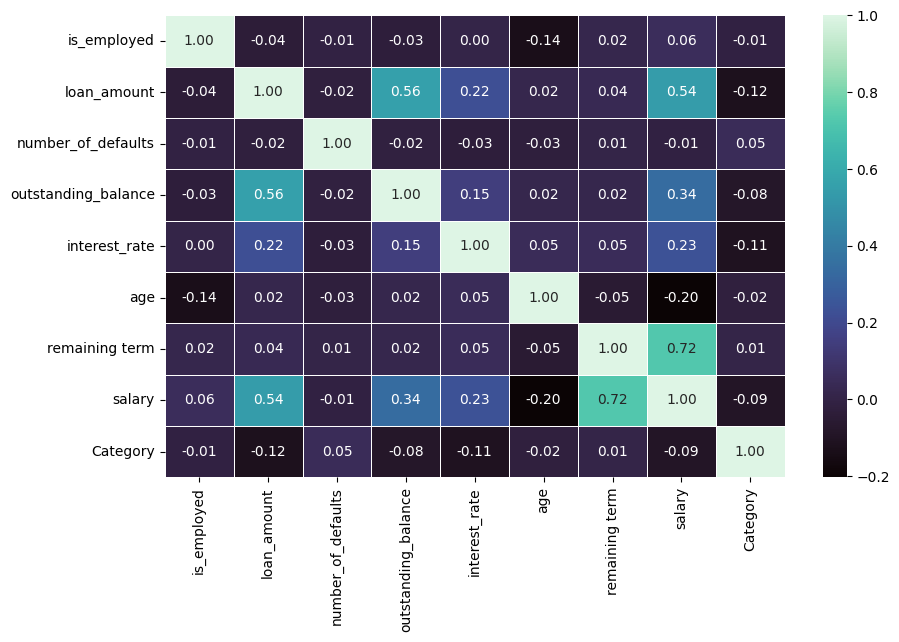

In [191]:
corrData = df.loc[:, [col for col in df if df[col].dtype not in ['category', 'object']]]
plt.figure(figsize=(10,6))
sns.heatmap(corrData.corr(), annot= True, linewidths=0.5,
                 fmt=".2f",
                 cmap="mako")


### THE SEEMS TO BE SOME TIGHT CORRELATION BETWEEN SOME FEATURES

`salary` and `loan amount`,  
`salary` and `loan remaining term`,
`loan amount` and `outstanding_balance`


# SECONDARY DATA HANDLING

## HANDLING MISSING VALUES


In [192]:
df.isna().sum()

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64

In [193]:
# df.loc[(df.job.isna())& (df.loan_amount>60000), 'job'] = 'Data Scientist'
# fill job with mode job Engineer
df.job.fillna('Data Analyst',inplace= True)
df.location.fillna('unknown',inplace= True)
df.isna().sum()

C:\Users\Augah\AppData\Local\Temp\ipykernel_15800\1643123120.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.fillna('Data Analyst',inplace= True)
C:\Users\Augah\AppData\Local\Temp\ipykernel_15800\1643123120.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

gender                   0
disbursemet_date         0
currency                 0
country                100
is_employed              0
job                      0
location                 0
loan_amount              0
number_of_defaults       0
outstanding_balance      0
interest_rate            0
age                      0
remaining term           0
salary                   0
marital_status           0
Loan Status              0
Category                 0
dtype: int64

## EARLIER

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using the XGB MODEL.
- We are going to use the custom made predict feature class.


In [194]:

print(df['marital_status'].value_counts())


marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64


## DATA PREPROCESSING


In [195]:
# convert the disbursement date to right date and time format.
import pandas as pd

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

In [196]:
# encode categorical variables

from sklearn.preprocessing import LabelEncoder


df['gender'] = df['gender'].map({"other":1, "female": 0,'male':2}).astype('int')




le = LabelEncoder()

categorical_features = [ 'currency', 'country', 'job', 'location']

for i, cat in enumerate(categorical_features):
    df[cat] = le.fit_transform(df[cat])
le.fit([ 'Defaulted','Did not default'])
if df['Loan Status'].dtype != 'int64':
    df['Loan Status'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')
df.head()

,gender,disbursemet_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Loan Status,Category
0,0,2022-10-29,0,0,True,8,0,39000.0,0,48653.011473,0.22,37,47,3230.038869,married,0,1
1,1,2020-06-06,0,0,True,8,8,27000.0,2,28752.062237,0.20,43,62,3194.139103,single,0,0
2,1,2023-09-29,0,0,True,6,7,35000.0,1,44797.554126,0.22,43,57,3330.826656,married,0,0
3,0,2022-06-22,0,0,True,3,20,24000.0,0,35681.496413,0.23,47,42,2246.797020,divorced,0,1
4,2,2023-02-08,0,0,True,6,3,19000.0,0,34156.055882,0.20,42,45,2310.858441,married,0,1


## EARLIER

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using an XGB MODEL.
- We are going to use the custom made predict feature class.


In [197]:
import importlib
import predict_feature
importlib.reload(predict_feature)
from predict_feature import Predict_Marital
import xgboost as xgb





mdl = Predict_Marital(df.drop('disbursemet_date', axis =1))
mdl.train()

preds, feature_importances = mdl.predict()

df.loc[df.marital_status  == ' ', 'marital_status']

df.loc[df.marital_status  == ' ', 'marital_status'] =pd.DataFrame(preds)[0].map({0:'single', 1:'married', 2:'divorced'}).to_numpy()
df['marital_status'] = df['marital_status'].map({'single':0, 'married':1, 'divorced': 2}).astype('int')

print(df.marital_status.value_counts())


score: 0.8999741935483871
marital_status
1    46198
2    27294
0    26508
Name: count, dtype: int64


In [198]:
# DATA SEPERATION
X = df.drop(['Loan Status', 'disbursemet_date'], axis=1)
y = df['Loan Status']

## FEATURE ENGINEERING

#### CREATE NEW FEATURES


In [199]:
## function to encode a categorical feature ordinaly with respect to another feature with mean
def group_sort_map(X, groupby_column, sort_by_column):
    """
    Group X by a given column, calculate the mean, sort by another column,
    and map the groupby column to its corresponding index after sorting.

    Parameters:
    - X (pd.DataFrame): The input DataFrame to process.
    - groupby_column (str): The column name to group by.
    - sort_by_column (str): The column name to sort by.

    Returns:
    - sorted_groupby_df (pd.DataFrame): The grouped and sorted DataFrame.
    - location_to_index (dict): A mapping of groupby column values to their sorted indices.
    """
    
    # 1. Group by the specified column and calculate the mean
    groupby_df = X.groupby(groupby_column).mean()
    
    # 2. Sort the resulting DataFrame by the specified column
    sorted_groupby_df = groupby_df.sort_values(by=sort_by_column)
    
    # 3. Map the groupby column to its corresponding index after sorting
    feature_to_index = {feature: index for index, feature in enumerate(sorted_groupby_df.index)}
    
    return  feature_to_index

# ordinally encode location by loan_amount mean per location
location_map=group_sort_map(X= X, groupby_column='location', sort_by_column='loan_amount' )
X['location'] = X['location'].map(location_map).astype('int')

# ordinally encode location by loan_amount mean per location
job_map=group_sort_map(X= X, groupby_column='job', sort_by_column='salary' )
X['job'] = X['job'].map(job_map).astype('int')



In [200]:
# independent binary features for loan_amount === 5000 and greater than 75000
X['loan_equal_5000'] = np.where(X.loan_amount==5000,1,0)
X['loan_>_75000'] = np.where(X.loan_amount>75000,1,0)

In [201]:
# create a feature for loan amount per job
X = X.assign(total_loan_amount_per_job=X.groupby('job')['loan_amount'].transform('mean'))

### Create new feature to capture job and location relationship
X['job_location_interact'] = np.log1p(np.sqrt(X['job']))/(X['location']+1)

#### SPLIT THE DATA


##### Add the location threshold classification in train data only to avoid data leakage since

##### since we are using the target varible


In [202]:
# Create a feature for threshold classification of locations
def location_thresh_classification(X_features, labels, apply_data, threshold= 0.2):
    X_features = X_features.copy()
    X_features['y'] = labels
    location_ratios = X_features.groupby('location')['y'].mean()
    location_ratios = location_ratios / (1 - location_ratios)
  
    ## Define a threshold for classification (example: 0.2)
    threshold = 0.2
    #drop the labels if features equal to the apply
    if apply_data.shape == X_features.shape:
        X_features.drop('y',axis = 1, inplace = True)
    ## Classify locations based on imbalance ratio

    X_features.drop (columns ='y', axis = 1, inplace = True)
    apply_data['location_class'] = apply_data['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
    return apply_data


# FEATURE SELECTION


CHECKING FOR ASSOCIATION BETWEEN CATEGORICAL VARIABLES USING CHI SQUARE AND P_VALUE


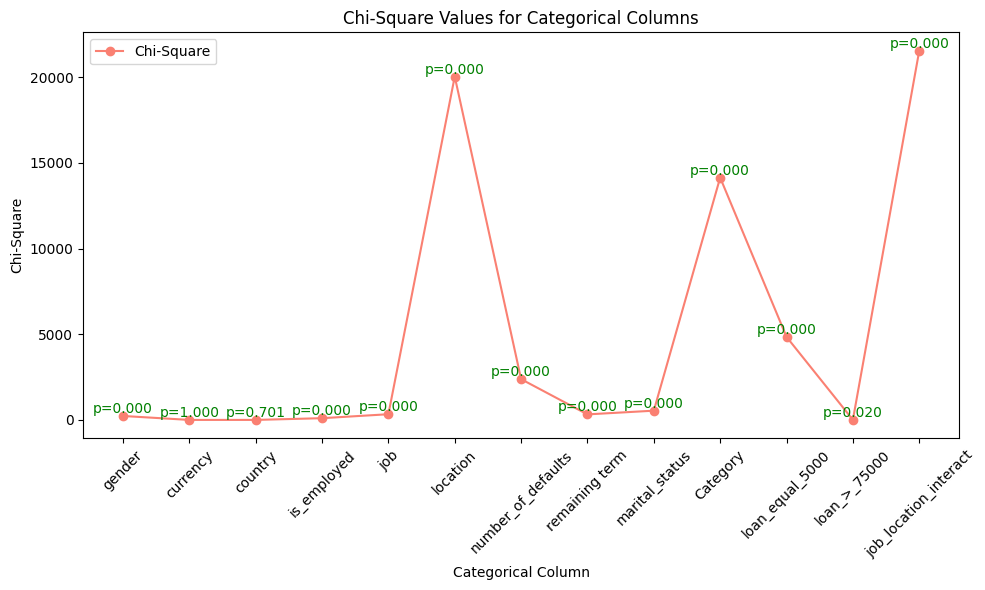

In [203]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Assume X and y are already defined and preprocessed dataframes
# Initialize the output dictionary
out = {'chi': [], 'p_value': [], 'col': []}

# Iterate over the categorical columns
for i in (X.columns[~X.columns.isin(['loan_amount', 'outstanding_balance', 'salary', 'total_loan_amount_per_job', 'age', 'interest_rate', 'remaining_term'])]):
    # Create a contingency table
    observed_data = pd.crosstab(X[i], y).to_numpy()

    # Perform the Chi-Square test
    chi2_statistic, pval, dof, expected_frequency = chi2_contingency(observed_data)

    # Store the results
    out['chi'].append(chi2_statistic)
    out['p_value'].append(pval)
    out['col'].append(i)

# Create a DataFrame for chi-square values and p-values
chi_X = pd.DataFrame(out)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(chi_X['col'], chi_X['chi'], marker='o', color='salmon', label='Chi-Square')

# Adding p-values as text on the plot
for i, (col, chi, pval) in enumerate(zip(chi_X['col'], chi_X['chi'], chi_X['p_value'])):
    ax.text(i, chi, f'p={pval:.3f}', ha='center', va='bottom', color='green', fontsize=10)

# Adding labels and title
ax.set_xlabel('Categorical Column')
ax.set_ylabel('Chi-Square')
ax.set_title('Chi-Square Values for Categorical Columns')
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.tight_layout()
plt.show()

- currency and country have a p value of greater than 0.05 indicating no significance with target variable.
- Location, category and job_location_interaction have very high chi coefficients indicating very strong significance.


#### USING VARIANCE THRESHOLDS TO SELECT FEATURES


In [204]:
from sklearn.feature_selection import  VarianceThreshold
from sklearn.linear_model import LassoCV

selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(X)
X.columns[~X.columns.isin(selector.get_feature_names_out())]



Index(['currency', 'country', 'interest_rate', 'loan_>_75000'], dtype='object')

In [205]:
# from sklearn.feature_selection import RFE


# model = RandomForestClassifier(n_estimators=100)
# rfe = RFE(model, n_features_to_select=10)
# fit = rfe.fit(X, y)
# selected_features_rfe = X.columns[~fit.support_]
# selected_features_rfe

- `currency` and `country` are in every selection method and should be removed.


In [206]:
X.drop(columns=[ 'country', 'currency'], inplace= True)



# PREDICTIVE MODELLING

## MODEL SELECTION

We are going to try the following algorithms with cross validation

1. Catboost
2. XGBOOST
3. RandomForestClassier
4. KNearest Neighbours
5. Logistic Regression
6. Decision Tress
7. LightGBM


In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []

def cross_val(X, y, show_plots= True):
    
    models = {
        # 'Logistic Regression': LogisticRegression(max_iter=100000),
        # 'Decision Tree': DecisionTreeClassifier(),
        # 'Random Forest': RandomForestClassifier(),
        # 'Xgboost': XGBClassifier(),
        'Catboost': CatBoostClassifier(),
        # 'Knn': KNeighborsClassifier(),
        # 'lightGBM': LGBMClassifier()
    }
    mean_scores = {}
    cv_results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='roc_auc');
        cv_results[name] = cv_scores
        mean_scores[name] = cv_scores.mean()
        fitted_models.append(model)

    cv_df = pd.DataFrame(cv_results)

    if show_plots == True:
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=cv_df)
        plt.title('Cross-Validation ROC-AUC Scores for Different Models')
        plt.xlabel('Model')
        plt.ylabel('ROC-AUC Score')
        plt.show()
        print(mean_scores )  


    return mean_scores, cv_results  


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=87)
X_train = location_thresh_classification(X_train, y_train, X_train)
# cross_val(X_train, y_train);
X_train

,gender,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Category,loan_equal_5000,loan_>_75000,total_loan_amount_per_job,job_location_interact,location_class
74643,1,True,0,12,33000.0,0,28216.434221,0.20,46,76,3578.444866,1,0,0,0,28943.415638,0.000000,1
15715,2,True,1,6,19000.0,1,40072.459395,0.21,44,64,2891.617633,1,1,0,0,28462.345121,0.099021,1
49102,0,True,2,4,53000.0,1,38889.431495,0.22,40,49,3251.821075,2,1,0,0,28305.637617,0.176275,0
5083,0,True,7,15,28000.0,0,30540.903863,0.22,39,72,3865.947134,1,0,0,0,38601.675978,0.080848,1
31839,2,True,2,2,33000.0,0,43730.422186,0.22,47,59,3057.064348,1,1,0,0,28305.637617,0.293791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0,True,7,15,45000.0,0,21471.249488,0.17,47,41,2449.341317,0,0,0,0,38601.675978,0.080848,1
21801,2,True,8,19,60000.0,0,28554.223335,0.17,37,47,3291.850248,0,1,0,0,43838.020247,0.067123,1
37436,2,True,3,13,32000.0,0,51486.466436,0.20,49,49,2454.369096,0,0,0,0,30460.972259,0.071789,1
37657,2,True,3,13,25000.0,0,32720.141363,0.23,46,56,2637.472911,1,0,0,0,30460.972259,0.071789,1


## **Earlier**
We identified that
1. There is a secondary distribution on loan amount from 1000 to 10000.
2. There are outliers on loan amount greater than 75000

We therefore want to train the model on that secondary distribution and the outliers and try to create ensemble models of the three models.

<Axes: ylabel='Frequency'>

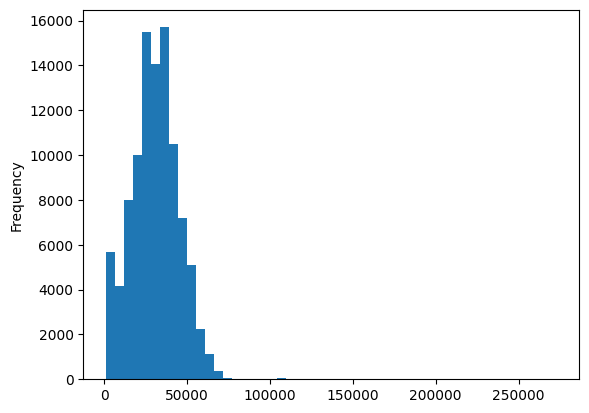

In [208]:
X['loan_amount'].plot.hist(bins= 50)

In [209]:
# # scores for less than 10000
# X_train_0_to_10000 = X_train[X_train['loan_amount']<=10000]
# y_train_0_to_10000 = y_train[X_train['loan_amount']<=10000]

# cross_val(X_train_0_to_10000, y_train_0_to_10000)

* There is a higher score of 0.97 with catboost having highest score

In [210]:
# X_train_outlier = X_train[X_train['loan_amount']>75000]
# y_train_outlier = y_train[X_train['loan_amount']>75000]

# cross_val(X_train_outlier, y_train_outlier)

* There is a higher score of 0.97 with catboost having highest score

## CHOSEN MODEL
The chosen model is Catboost.
### REASONS:-
1.
2.
3.


### ASSESS THE CHOSEN MODEL FOLDS SCORE

In [211]:
from numpy import interp
from sklearn.metrics import auc


def plot_roc(X, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

    

In [212]:
# plot_roc(X_train, y_train, XGBClassifier(), 5)
# X_train


* The folds are indeed even

# MODEL EVALUATION 

### BASELINE MODEL

In [213]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# function to evaluate our model
def train_evaluate_model(X_train, y_train, X_test, y_test,model = CatBoostClassifier(verbose =0)):
    # Initialize and train the CatBoost model
    model.fit(X_train, y_train);
    
    # Apply any additional preprocessing to the test set if needed
    X_test_processed = location_thresh_classification(X_train, y_train, X_test)
    
    # Predict on the test set
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
    }, model



In [214]:

base_model_metrics, _= train_evaluate_model(X_train, y_train, X_test, y_test)
for metric, value in base_model_metrics.items():
    print(f"{metric}: {value}")


Accuracy: 0.9371
Precision: 0.9096989966555183
Recall: 0.6404305415405315
F1 Score: 0.7516778523489933
ROC AUC: 0.918421487283478


**We are going to try an ensemble model using :-**
1. points with loan amount less than 10000
2. points with loan amount greater than 75000 (outliers)
3. base model for the rest of the points

In [215]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# function to classify for different loan_amount conditions
def train_and_evaluate_models(X_train, y_train, X_test, y_test):

    X_test = location_thresh_classification(X_train, y_train, X_test)
    models = {
        'loan under 10000': CatBoostClassifier(verbose=0),
        'loan above 75000': CatBoostClassifier(verbose=0),
        'base_model for loan inbetween': CatBoostClassifier(verbose=0)
    }
    
    # Define conditions for training subsets
    conditions = {
        'loan under 10000': X_train['loan_amount'] < 10000,
        'loan above 75000': X_train['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_train['loan_amount'] > 0) & (X_train['loan_amount'] < 1000000)
    }
    
    # Train models
    for model_name, condition in conditions.items():
        X_train_subset = X_train[condition]
        y_train_subset = y_train[condition]
        models[model_name].fit(X_train_subset, y_train_subset)

    # Define test conditions
    test_conditions = {
        'loan under 10000': X_test['loan_amount'] < 10000,
        'loan above 75000': X_test['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_test['loan_amount'] >= 10000) & (X_test['loan_amount'] <= 75000)
    }
    
    # Evaluate models
    def evaluate_model(model, X, y):
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
        return {
            "ROC AUC": roc_auc_score(y, y_pred_proba),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1 Score": f1_score(y, y_pred),
        }

    metrics = {}
    for model_name, condition in test_conditions.items():
        X_test_subset = X_test[condition]
        y_test_subset = y_test[condition]
        metrics[model_name] = evaluate_model(models[model_name], X_test_subset, y_test_subset)

    return models, metrics


In [216]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

#function to create ensemble model
def ensemble_model(models, X_test, y_test):
    # Initialize the prediction probabilities array
    y_pred_proba = np.zeros_like(y_test, dtype=float)
    y_pred = np.zeros_like(y_test, dtype=int)

    # Create masks based on loan_amount conditions
    mask0 = X_test['loan_amount'] < 10000
    mask1 = X_test['loan_amount'] > 75000
    mask2 = (~(mask0 | mask1))

    # Predict probabilities for different conditions
    y_pred_proba[mask0] = models['loan under 10000'].predict_proba(X_test[mask0])[:, 1]
    y_pred[mask0] = models['loan under 10000'].predict(X_test[mask0])

    y_pred_proba[mask1] = models['loan above 75000'].predict_proba(X_test[mask1])[:, 1]
    y_pred[mask1] = models['loan above 75000'].predict(X_test[mask1])

    y_pred_proba[mask2] = models['base_model for loan inbetween'].predict_proba(X_test[mask2])[:, 1]
    y_pred[mask2] = models['base_model for loan inbetween'].predict(X_test[mask2])

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "ROC AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }




In [217]:
# compare base and ensemble model
models, metrics = train_and_evaluate_models(X_train, y_train, X_test, y_test)
ensemble_metrics = ensemble_model(models, X_test, y_test)
# Print ensemble metrics
print("Ensemble Model Metrics:")
print()
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value}")

Ensemble Model Metrics:

ROC AUC Score: 0.9182664338870511
Accuracy: 0.93675
Precision: 0.9066666666666666
Recall: 0.6404305415405315
F1 Score: 0.7506406465602208


**Compare the base and ensemble models**

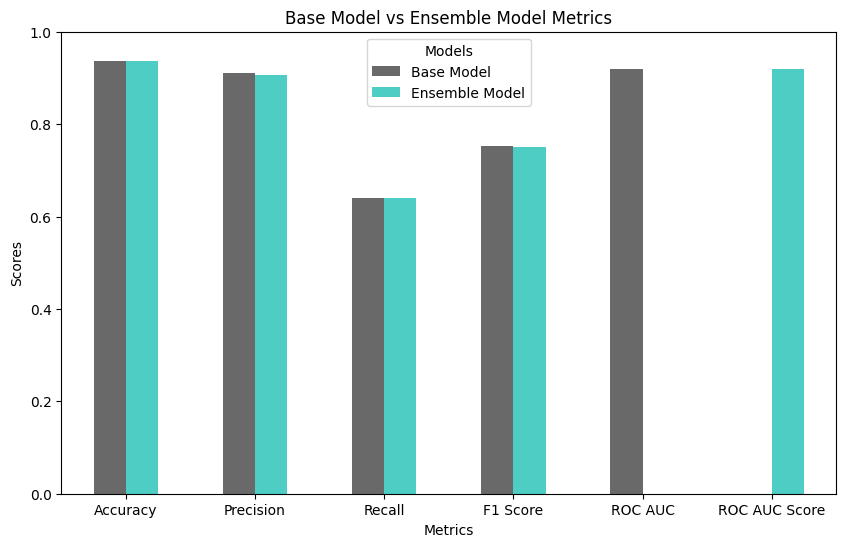

In [218]:
import matplotlib.pyplot as plt
import pandas as pd

def compare_models(base_model_metrics, ensemble_metrics):
    # Convert the metrics dictionaries to pandas DataFrames
    metrics_df = pd.DataFrame({'Base Model': base_model_metrics, 'Ensemble Model': ensemble_metrics})

    # Plot the metrics
    metrics_df.plot.bar(figsize=(10, 6), color=['#696969', '#4ecdc4'], rot=0)


    # Set plot labels and title
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Base Model vs Ensemble Model Metrics')
    plt.ylim(0, 1)  # Set y-axis limit for better comparison
    plt.legend(title='Models')

    # Show the plot
    plt.show()
compare_models(base_model_metrics, ensemble_metrics)    


* The `ensemble model` is literally the same as the `base model`
* To avoid complexities, we stick to the simple `base model`.

## **Feature Importance**


In [219]:
_,model = train_evaluate_model(X_train, y_train, X_test, y_test)


In [220]:
feature_importances = pd.DataFrame(model.feature_importances_).T
feature_importances.columns = model.feature_names_
feature_importances.T.sort_values(by=0, ascending=False)h

,0
age,13.498653
interest_rate,11.553352
total_loan_amount_per_job,11.345941
loan_amount,10.743077
location,8.780671
salary,5.630958
remaining term,5.498842
job_location_interact,4.732100
location_class,4.595667
job,4.449305


In [221]:
f = pd.DataFrame(model.feature_importances_).T
f.columns = model.feature_names_
f.T.sort_values(by=0)


,0
loan_>_75000,0.016448
loan_equal_5000,0.326735
is_employed,1.895829
gender,2.570449
number_of_defaults,2.829538
marital_status,3.637614
outstanding_balance,3.720410
Category,4.174411
job,4.449305
location_class,4.595667


In [222]:
from sklearn.metrics import accuracy_score
catboost_model2 = CatBoostClassifier()
y_train_75000= y_train[X_train['loan_amount']>75000].copy()
X_train_75000= X_train[X_train['loan_amount']>75000].copy()
y_test_75000= y_test[X_test['loan_amount']>75000].copy()
X_test_75000= X_test[X_test['loan_amount']>75000].copy()

catboost_model2.fit(X_train_75000, y_train_75000)
X_test_75000 = location_thresh_classification(X_train, y_train, X_test_75000)
# Predict on the test set
y_pred = catboost_model2.predict(X_test_75000)
y_pred_proba = catboost_model2.predict_proba(X_test_75000)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_75000, y_pred)
precision = precision_score(y_test_75000, y_pred)
recall = recall_score(y_test_75000, y_pred)
f1 = f1_score(y_test_75000, y_pred)
roc_auc = roc_auc_score(y_test_75000, y_pred_proba)

print(f'accuracy: {accuracy}')
print(f'pre: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'auc: {roc_auc}')


Learning rate set to 0.00569
0:	learn: 0.6863364	total: 4.02ms	remaining: 4.01s
1:	learn: 0.6785261	total: 7.92ms	remaining: 3.95s
2:	learn: 0.6697205	total: 12.1ms	remaining: 4.03s
3:	learn: 0.6639498	total: 15.4ms	remaining: 3.85s
4:	learn: 0.6555926	total: 18.3ms	remaining: 3.64s
5:	learn: 0.6490284	total: 21.8ms	remaining: 3.61s
6:	learn: 0.6436740	total: 24.7ms	remaining: 3.51s
7:	learn: 0.6389237	total: 26.6ms	remaining: 3.3s
8:	learn: 0.6342328	total: 30.3ms	remaining: 3.34s
9:	learn: 0.6271370	total: 34.2ms	remaining: 3.39s
10:	learn: 0.6192337	total: 39.1ms	remaining: 3.51s
11:	learn: 0.6134854	total: 42.3ms	remaining: 3.48s
12:	learn: 0.6074518	total: 45.6ms	remaining: 3.46s
13:	learn: 0.6003184	total: 134ms	remaining: 9.42s
14:	learn: 0.5941334	total: 163ms	remaining: 10.7s
15:	learn: 0.5871054	total: 176ms	remaining: 10.8s
16:	learn: 0.5815606	total: 182ms	remaining: 10.5s
17:	learn: 0.5751982	total: 187ms	remaining: 10.2s
18:	learn: 0.5709425	total: 192ms	remaining: 9.91s


In [223]:
from sklearn.metrics import accuracy_score
catboost_model1 = CatBoostClassifier()
y_train_under_10000 = y_train[(X_train['loan_amount']<= 10000) ].copy()
X_train_under_10000 = X_train[(X_train['loan_amount']<= 10000) ].copy()
y_test_under_10000 = y_test[(X_test['loan_amount']<= 10000)].copy()
X_test_under_10000 = X_test[(X_test['loan_amount']<= 10000)].copy()
catboost_model1.fit(X_train_10000, y_train_10000)
X_test_10000 = location_thresh_classification(X_train, y_train, X_test_10000)
# Predict on the test set
y_pred = catboost_model1.predict(X_test_10000)
y_pred_proba = catboost_model1.predict_proba(X_test_10000)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_10000, y_pred)
precision = precision_score(y_test_10000, y_pred)
recall = recall_score(y_test_10000, y_pred)
f1 = f1_score(y_test_10000, y_pred)
roc_auc = roc_auc_score(y_test_10000, y_pred_proba)

print(f'accuracy: {accuracy}')
print(f'pre: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'auc: {roc_auc}')
X_train

NameError: name 'X_train_10000' is not defined

In [ ]:
y_pred_proba = np.zeros_like(y_test, dtype=float)

# # Predict with model0 for loan_amount < 10000
# mask0 = X_test['loan_amount'] < 10000
# y_pred_proba[mask0] = above_75000_model.predict_proba(X_test[mask0])[:, 1]

# Predict with model1 for loan_amount > 75000
mask1 = X_test['loan_amount'] > 75000
y_pred_proba[mask1] = under_10000_model.predict_proba(X_test[mask1])[:, 1]

# Predict with model2 for 10000 <= loan_amount <= 75000
mask2 = (~(X_test['loan_amount' ]<10000)) & (~(X_test['loan_amount'] > 75000))
y_pred_proba[mask2] = base_model.predict_proba(X_test[mask2])[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.7692087383582289

In [ ]:
from sklearn.metrics import accuracy_score


X_test = location_thresh_classification(X_train, y_train, X_test)
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'accuracy: {accuracy}')
print(f'pre: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'auc: {roc_auc}')

accuracy: 0.9365294058711552
pre: 0.8992502343017807
recall: 0.6459104678559408
f1: 0.7518119490695396
auc: 0.9119903124114195


In [ ]:
plt.figure(figsize=(12,12))
X_test[(probas ==0)& (y_test ==1)].hist(figsize=(12,12))
# classification_report(y_test, probas)

NameError: name 'probas' is not defined

<Figure size 1200x1200 with 0 Axes>

In [ ]:
final_df
# df.drop(columns=['disbursemet_date', 'marital_status']).groupby('location').mean().sort_values('loan_amount')




NameError: name 'final_df' is not defined

Xgboost, Catboost, RandomForest and LightGBM roughly have the same same score


## FEATURE ENGINEERING


In [ ]:
# import pandas as pd

# def encode_locations_by_mean_loan_amount(df, location_col='location', loan_amount_col='loan_amount'):
#     """
#     Group the DataFrame by location, calculate the mean loan amount for each location,
#     sort by the mean loan amount, and map the locations to their corresponding indices.
    
#     Parameters:
#     - df (pd.DataFrame): The input DataFrame containing location and loan amount columns.
#     - location_col (str): The name of the location column.
#     - loan_amount_col (str): The name of the loan amount column.
    
#     Returns:
#     - pd.DataFrame: The DataFrame with an additional column for the encoded location.
#     """
#     # Group by location and calculate the mean loan amount
#     location_mean_loan = df.groupby(location_col)[loan_amount_col].mean().reset_index()
    
#     # Sort by the mean loan amount
#     location_mean_loan = location_mean_loan.sort_values(by=loan_amount_col).reset_index(drop=True)
    
#     # Create a mapping of location to its corresponding index
#     location_mapping = {loc: idx for idx, loc in enumerate(location_mean_loan[location_col])}
    
#     # Map the location column in the original DataFrame to its corresponding index
#     df['location_encoded'] = df[location_col].map(location_mapping)
    
#     return df

# # Example usage:
# # Assuming X_train is your DataFrame with 'location' and 'loan_amount' columns
# X_train_encoded = encode_locations_by_mean_loan_amount(X_train, location_col='location', loan_amount_col='loan_amount')

# # Display the first few rows of the encoded DataFrame
# X_train['location'] = X_train_encoded['location_encoded'] 


In [ ]:

# binary categories for loan_amount === 5000 and greater than 75000
X_train['less_than_10000'] = np.where(X_train.loan_amount==5000,1,0)
X_train['greater_than_75000'] = np.where(X_train.loan_amount>75000,1,0)

In [ ]:
# Create a feature for threshold classification of locations
X_train['y'] = y_train
location_ratios = X_train.groupby('location')['y'].mean()
location_ratios = location_ratios / (1 - location_ratios)

## Define a threshold for classification (example: 0.2)
threshold = 0.2

## Classify locations based on imbalance ratio
X_train['location_class'] = X_train['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
X_train.drop(columns= 'y', inplace= True)

In [ ]:
# ## create a feature for loan amount per job
# loan_amount_per_job = X_train.groupby('job')['loan_amount'].mean().reset_index()
# loan_amount_per_job.rename(columns={'loan_amount': 'total_loan_amount_per_job'}, inplace=True)

# # # # Merge with original DataFrame
# X_train = X_train.merge(loan_amount_per_job, on='job', how='left')

# ### Create new feature to capture job and location relationship
# X_train['job_location_interact'] = np.log1p(np.sqrt(X_train['job']))/(X_train['location']+1)

gender                       0
is_employed                  0
job                          0
location                     0
loan_amount                  0
number_of_defaults           0
outstanding_balance          0
interest_rate                0
age                          0
remaining term               0
salary                       0
marital_status               0
Category                     0
less_than_10000              0
greater_than_75000           0
total_loan_amount_per_job    0
job_location_interact        0
location_class               0
dtype: int64

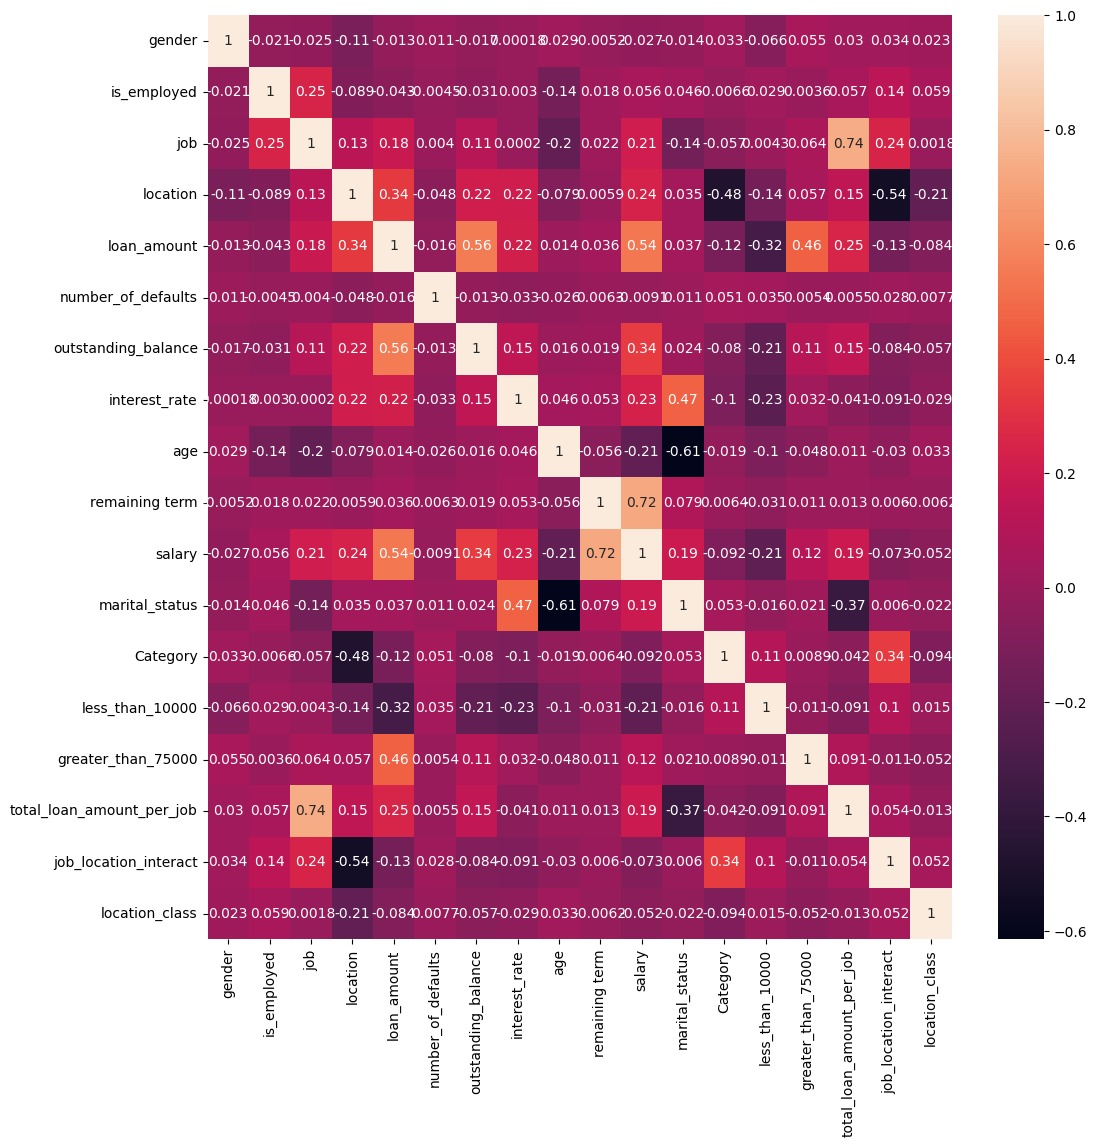

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(), annot= True)
X_train.isna().sum()

In [ ]:
# def group_sort_map(X, groupby_column, sort_by_column):
#     """
#     Group X by a given column, calculate the mean, sort by another column,
#     and map the groupby column to its corresponding index after sorting.

#     Parameters:
#     - X (pd.DataFrame): The input DataFrame to process.
#     - groupby_column (str): The column name to group by.
#     - sort_by_column (str): The column name to sort by.

#     Returns:
#     - sorted_groupby_df (pd.DataFrame): The grouped and sorted DataFrame.
#     - location_to_index (dict): A mapping of groupby column values to their sorted indices.
#     """
    
#     # 1. Group by the specified column and calculate the mean
#     groupby_df = X.groupby(groupby_column).mean()
    
#     # 2. Sort the resulting DataFrame by the specified column
#     sorted_groupby_df = groupby_df.sort_values(by=sort_by_column)
    
#     # 3. Map the groupby column to its corresponding index after sorting
#     location_to_index = {location: index for index, location in enumerate(sorted_groupby_df.index)}
    
#     return sorted_groupby_df, location_to_index


# a,b =group_sort_map(X= X, groupby_column='location', sort_by_column='loan_amount' )
# X['location'] = X['location'].map(b).astype('int')
# # X['job'] = X['location'].map(b).astype('int')
# a

: 

In [ ]:

# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
cross_val(X_train, y_train, show_plots=True);


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9506, number of negative: 54371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 63877, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148817 -> initscore=-1.743908
[LightGBM] [Info] Start training from score -1.743908
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9506, number of negative: 54371
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

- There is an increase in our cross validation scores.


## KMEANS CLUSTERING


#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Assume X and y are your feature and target DataFrames respectively
X['y'] = y

# Filter the DataFrame to find the subset where location == 0
location_to_find_neighbour = X[X['location'] == 24]

# Fit the NearestNeighbors model on the entire dataset excluding 'location'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['location']))
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
nn_model.fit(X_scaled)

# Find nearest neighbors for the subset where location == 0
location_to_find_neighbour_scaled = scaler.transform(location_to_find_neighbour.drop(columns=['location']))
distances, indices = nn_model.kneighbors(location_to_find_neighbour_scaled)

# Extract the nearest neighbors indices
neighbors_indices = indices[:, 1]  # Taking the second neighbor as the first is the point itself

# Identify the points where the nearest neighbor has location value of 1
# points_with_nn_location_1 = location_to_find_neighbour.index[[
#     X.iloc[neighbor_idx]['location'] == 0

#      for neighbor_idx in neighbors_indices
# ]]

# # Filter the original DataFrame to get these points
# filtered_points = X.loc[points_with_nn_location_1]
# plt
# # Display the filtered DataFrame
# filtered_points.groupby(pd.cut(filtered_points['loan_amount'], np.arange(0,350000,20000))).size()
# X.iloc[neighbors_indices]['location'].value_counts()


ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

# inertias = []

# for i in range(1,20):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
#     inertias.append(kmeans.inertia_)


# plt.figure(figsize=(10,5))
# plt.title('ELBOW METHOD')
# plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');


- There seem to be anomalies at k = 7. Lets investigate


In [ ]:
# km = KMeans(n_clusters=8, random_state=0)
# np.random.seed(76)
# df['clusters'] = km.fit_predict(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)
# sns.countplot(df,x= 'clusters', palette='magma', hue='Loan Status');


In [ ]:
# df['low_2'] = np.where((df['clusters'].isin([4,7])),1,0)
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)

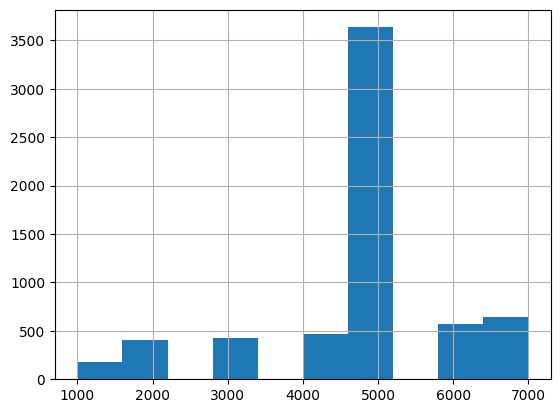

In [ ]:
df[df['loan_amount'] <8000]['loan_amount'].hist();

- Since there is a secondary distribution at loan amount = 5000
- Lets train a model on points with loan amount from 0 to 8000


In [ ]:
# X_train, X_test, y_train, y_test,_,__ = split_data(df[df['loan_amount']<=10000])

# cross_val(X_train, y_train)

In [ ]:
from sklearn.ensemble import IsolationForest

# iso = IsolationForest( contamination=0.05, n_jobs=-1, random_state=78)
# df['iso'] = iso.fit_predict(df.drop(['Loan Status'], axis =1))
# df1 = df
# X_train, X_test, y_train, y_test,_,__ = split_data(df[df['loan_amount']<10000])
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)


In [ ]:
# from xgboost import XGBClassifier
# from sklearn.metrics import confusion_matrix, roc_auc_score

# x = CatBoostClassifier()
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# x.fit(X_train, y_train)
# preds = x.predict(X_test)
# # confusion_matrix(y_test, preds)
# print(roc_auc_score(y_test, preds))
# # preds
# preds = x.predict(X_test)

# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'max_depth': [-1, 10, 20, 30],
#     'learning_rate': [0.1, 0.01,1, 0.001],
#     'n_estimators': [100, 200, 500],
#     'min_child_samples': [20, 50, 100],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X, y)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)



In [ ]:
# X_test[(preds==0) & (y_test ==1) ]['location'].hist(figsize =(12,12) ,bins = 24);
# X_test[(preds==1) & (y_test ==1) ]['location'].hist(figsize =(12,12) ,bins = 30);
best_params

NameError: name 'best_params' is not defined

In [ ]:
f = pd.DataFrame(x.feature_importances_.T, index= x.feature_names_in_).sort_values(by=0, ascending= False)
# pd.DataFrame(x.feature_importances_)
f


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert cv_results to DataFrame for easier plotting
cv_df = pd.DataFrame(cv_results)
   

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Cross-Validation ROC-AUC Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('ROC-AUC Score')
plt.show()
cv_scores = {}
for name, score in cv_results.items():
    cv_scores[name] = cv_results[name].mean()

cv_scores 
# cv_results

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');

In [ ]:
# Fit the Isolation Forest model
from sklearn.ensemble import IsolationForest

X = df.drop(columns=['disbursemet_date', 'Loan Status'])
iso_forest = IsolationForest(contamination=0.007, random_state=42)
iso_forest.fit(X)
# Predict outliers
outlier_predictions = iso_forest.predict(X)

# Convert predictions to boolean: 1 for inliers, -1 for outliers
outliers = outlier_predictions == -1
inliers = outlier_predictions == 1

# Count the number of outliers
n_outliers = np.sum(outliers)
print(f'Number of outliers detected: {n_outliers}')
# Plot the inliers and outliers
# plt.figure(figsize=(8, 4))
# plt.scatter(X[inliers, 0], X[inliers, 1], color='blue', label='Inliers')
# plt.scatter(X[outliers, 0], X[outliers, 1], color='red', label='Outliers')
# plt.title('Isolation Forest Outlier Detection')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.show()

X[outliers]

In [ ]:
df[outliers]['loan_amount'].hist(bins =50)

In [ ]:
from sklearn.metrics import silhouette_score


results = []

for i in range(2,3):
    for r in range(3):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(num_df_scaled)
        sil_ave = silhouette_score(num_df_scaled, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8});

In [ ]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your data

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

# Get today's date
today = pd.Timestamp.today()

# Calculate loan length in days
df['loan_length'] = (today - df['disbursemet_date']).dt.days


print(df[['disbursemet_date', 'loan_length']].head())


df['interest'] = (np.sqrt(df.loan_amount)* np.exp(df.interest_rate)* np.log(df['loan_length']))
df['u']=np.where((df.loan_amount)<df.outstanding_balance, 1.1,1)
df['t']=(np.sqrt(df['loan_length']/df['loan_amount'])/(df['interest_rate'])**3.3)

df['w'] = (df['remaining term'])**(1/3)/(df['interest_rate'])**4
df['u'] = (df['u'])/(df['interest_rate'])**5
df['y'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted':1})
df['loan_type'] = pd.cut(df['loan_length'], bins= np.arange(0,1800, 400), labels= False)
df['remaining_bucket'] = (pd.cut(df['remaining term'], bins=np.arange(0,130,20), labels=False))
ome =df[['u','y','w' ,'interest_rate', 'age', 'interest', 't', 'loan_type', 'remaining_bucket' ]].corr()
# df[df['remaining_bucket']==0].hist(bins=50)
# sns.heatmap(ome, annot=True)
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['age', 'interest_rate']])

# Get feature names after polynomial transformation
# poly_feature_names = poly.get_feature_names(input_features=['age', 'interest_rate'])

# Create a DataFrame with polynomial features
df_poly = pd.DataFrame(poly_features)

# Concatenate the original DataFrame with the polynomial features
data = pd.concat([df, df_poly], axis=1)
data.tail(20)

# Now you can use 'data' DataFrame which includes both original and polynomial features




In [ ]:
print(df.groupby('loan_type').median())

### Handle missing values


In [ ]:
df.isna().sum()

In [ ]:
##drop location missing rows

df.dropna(subset=['country', 'location'], inplace=True)
df.isna().sum()

- too many missing location values so can't drop information.
- to predict a value of a column using random forest and impute the prediction on the missing slot.


In [ ]:
## to many values fitting a model to predict  
# df = df.loc[df.location!= 'Redcliff']
# print(df.location.value_counts())
# import importlib
# import predict_feature
# importlib.reload(predict_feature)
# from predict_feature import Predict_Job
# import xgboost as xgb





# mdl = Predict_Job(df)
# mdl.train()
df.dropna(axis=0)


In [ ]:

# import importlib
# import predict_feature
# importlib.reload(predict_feature)
# preds =mdl.predict()
# preds

In [ ]:
# # impute preds back into the dataset 
# # retaining mapping
# mapping = {0: 'Teacher', 1:'Nurse', 2:'Doctor', 3:'Data Analyst', 4:'Software Developer',
#        5:'Accountant',6: 'Lawyer',7: 'Engineer',8:'Data Scientist'}

# job = []

# for i in mdl.predict():
#     job.append(mapping[i])

# df.loc[df.job.isna(), 'job'] = job    

df.isna().sum()

# Modelling


### Split the data into training and sets by using train_test_split.


In [ ]:
# selected_rows = df[(df.age<40)& (df.interest_rate<0.16)].sample(n=40000, replace= True)
# elected_rows_duplicated = pd.concat([selected_rows] * 20, ignore_index=True)  # Duplicate 20 times
# augmented_data = pd.concat([df, selected_rows])

# # Reset index if needed
# augmented_data.reset_index(drop=True, inplace=True)
# df = augmented_data

# augmented_data['Loan Status'].value_counts()


In [ ]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = df["Loan Status"].map({'Did not default':0, 'Defaulted':1})

# Separate the X variable, the features
X = df.drop(columns="Loan Status")
print(y.head(5))

# Check the balance of our target values
print(y.value_counts())
(X.head(3))


## DATA PREPROCESSING


In [ ]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your data

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

# Get today's date
today = pd.Timestamp.today()

# Calculate loan length in days
df['loan_length'] = (today - df['disbursemet_date']).dt.days


print(df[['disbursemet_date', 'loan_length']].head())


In [ ]:
# Preprocess the data before initial training 
from sklearn.preprocessing import StandardScaler


#dummy encode categorical variables
X = pd.get_dummies(X, columns=['marital_status','gender' ,'job', 'location', 	'currency',	'country'])
X

# #convert column to datetime format
# X['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format= '%Y %m %d')

# encode the target y variable
if y.dtype not in ['int64', 'int32']:
    y = y.map({'Did not default': 0, "Defaulted": 1}).astype('int')
y

X.head()



## SPLITTING THE DATA TO HAVE A GLOBAL VALIDATION TEST SET


In [ ]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
feature_names = X_train.columns

In [ ]:
y_train.value_counts()

- #### Fit model. N.B, chose random forest due to its feature importance feature


In [ ]:
#fitting random forest to my model 
clf = RandomForestClassifier()
xgboost = xgb.XGBClassifier
clf.fit(X_train,y_train)


In [ ]:
#show metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,confusion_matrix


def viewMetric(clf):
    y_preds = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_preds)
    
    print(classification_report(y_test, y_preds))
    print(roc_auc_score(y_test, y_preds))

    # Calculate ROC curve (fpr, tpr, thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)

    # Calculate AUC score
    
    # sns.heatmap(confusion_matrix(y_preds, y_test), annot=True)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    

viewMetric(clf)



### Take the first columns whose feature importance sum is equal to 5%

### Remove the rest


In [ ]:
#sort and remove
feature_importances = pd.DataFrame(clf.feature_importances_).T
feature_importances.columns = clf.feature_names_in_
feature_importances = feature_importances.T.sort_values(by=0)

feature_importances.loc['loan length']


In [ ]:
# remove columns
X_train = X_train.drop(['country_zimbabwe', 'currency_USD', 'location_Kariba',
       'location_Zvishavane', 'location_Nyanga', 'location_Kadoma',
       'location_Hwange', 'location_Chimanimani', 'location_Beitbridge',
       'location_Chivhu', 'location_Marondera', 'location_Gweru',
       'marital_status_ ', 'location_Bulawayo', 'location_Harare', 'is_employed',
       'location_Mutare', 'location_Masvingo', 'location_Rusape'], axis = 1)
X_test = X_test.drop(['country_zimbabwe', 'currency_USD', 'location_Kariba',
       'location_Zvishavane', 'location_Nyanga', 'location_Kadoma',
       'location_Hwange', 'location_Chimanimani', 'location_Beitbridge',
       'location_Chivhu', 'location_Marondera', 'location_Gweru',
       'marital_status_ ', 'location_Bulawayo', 'location_Harare',
       'location_Mutare', 'location_Masvingo', 'location_Rusape', 'is_employed'], axis = 1)


We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 5 different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. Xgboost
5. Multi-layer-perceptron


In [ ]:
# #train on different models

# from sklearn.neighbors import KNeighborsClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_classification
# import matplotlib.pyplot as plt
# from sklearn.model_selection import cross_val_score


# xgboost = xgb.XGBClassifier()
# logistic = LogisticRegression(max_iter=1000)
# clf = RandomForestClassifier()
# KNN = KNeighborsClassifier()
# roc_auc_dict = {}
# threshold = 0.2
# scaler =StandardScaler()


# def model_train(X_train,y_train, scaler = scaler):
#   #model dictionary
#   models = [
#       {"name": 'RF', "estimator": clf },
#             {"name":"logistic" , "estimator": logistic },
#             {"name":"KNN" , "estimator": KNN },
#               {"name":"xgboost" , "estimator": xgboost }
#             ]

  
 
#   for model in models: 
      
#       model['estimator'].fit((X_train), y_train)
#       y_prob = model['estimator'].predict_proba((X_test))[:, 1]
#       preds = (y_prob > threshold).astype(int)
#       # print(roc_auc_score(y_test, preds))
#       preds
      
#       roc_auc_dict[model['name']] = roc_auc_score(y_test, preds)
  


  



#   # Build the neural network model for binary classification
#   model = Sequential([
#       Dense(64, input_shape=(X_train.shape[1],), activation='relu'),  # First hidden layer
#       Dense(32, activation='relu'),  # Second hidden layer
#       Dense(1, activation='sigmoid')  # Output layer for binary classification
#   ])

#   # Compile the model
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#   # Train the model
#   history = model.fit(scaler.fit_transform(X_train), y_train, epochs=5, batch_size=8, validation_split=0.2)


#   # Make predictions
#   y_pred_prob = model.predict(X_test)

#   # Convert probabilities to binary predictions
#   y_pred = (y_pred_prob > 0.2).astype(int)
#   roc_auc_dict['nueral network mlp'] = roc_auc_score(y_test,y_pred)
#   print(roc_auc_dict)


#   return pd.DataFrame(roc_auc_dict, index = ['roc_auc_score']).T.plot.bar()

# model_train(X_train, y_train,scaler= scaler)






## ROC_AUC SCORES WITH CROSS VALIDATION


In [ ]:
import numpy as np
import pandas as pd
# from sklearn.base import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, make_scorer
# import xgboost as xgb
import statistics
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# cross val score with threshold function 
def cross_val_with_threshold(estimator, X ,y, metric,threshold, cv=5, ):

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
        auc_scores = []
        

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            estimator.fit(X_train, y_train)
            probas = estimator.predict_proba(X_test)[:, 1]
            # probas = np.where(X_test['low_risk'] == 1, probas + 0.03, probas)

            np.where

            preds = (probas >= threshold).astype(int)
            auc_scores.append(metric(y_test, preds))
         
        


    
        return statistics.mean(auc_scores)

models = [
    # {"name": 'Random Forest', "estimator": RandomForestClassifier(n_estimators=100, random_state=42)},
    # {"name": "Logistic Regression", "estimator": LogisticRegression(max_iter=1000, random_state=42)},
    # {"name": "KNN", "estimator": KNeighborsClassifier()},
    {"name": "XGBoost", "estimator": xgb.XGBClassifier()},
    # {"name": "lda", "estimator": LinearDiscriminantAnalysis()}
]

def cross_val_scores(threshold, X,y):
    
    
    
    scores_dict = {}
    for metric in [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score]:
        metric_values = []
        for model in models:
         
        
            metric_score = cross_val_with_threshold(model['estimator'], X, y,metric, cv= 5, threshold=threshold, )
            metric_values.append(metric_score)
        metric_name = metric.__name__
        scores_dict[metric_name] = metric_values
    return scores_dict   
        

# Define models
print(X_train.shape, y_train.shape)

score_dict = cross_val_scores( X=X_train, y=y_train,threshold=0.2, )
print(score_dict)
pd.DataFrame(score_dict, index=[model['name'] for model in models]).plot.bar()
plt.show()


## Chosen Model: XGBoost

#### Explanation

- Our data has very informative outliers so its unwise to remove or transform them.
  The best is to leave them
- It is generally giving the best mark among all tried models

#### Assumptions:

- Assumes that features are informative and not highly correlated to avoid overfitting.

#### Limitations:

- Can be sensitive to noisy data and requires careful tuning of hyperparameters.


# FEATURE ENGINEERING


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

#take the kmeans component as a column
kM = KMeans(n_clusters=2)
kmeans = kM.fit(X_train, y_train)
kmeans = kM.transform(X_train)
kmeans1 = kM.transform(X_test)
pca = PCA(n_components=1).fit_transform(X_test[['interest_rate', 'age']])


#age and interset rate on the plot seperates classes, create a new feature from them

X_train['rate_age_ratio'] = (X_train['interest_rate'] * X_train['age'])**4
X_test['rate_age_ratio'] = (X_test['interest_rate'] * X_test['age'])**4

X_train['K1'] = kmeans.T[0]
X_train['predicted_low_default'] = np.where((X_train['age'] < 40) & (X_train['interest_rate'] < 0.17), 1, 0)


X_test['K1'] = kmeans1.T[0]
X_test['predicted_low_default'] = np.where((X_test['age'] < 40) & (X_test['interest_rate'] < 0.17), 1, 0)

#add new feature. date to income ratio
X['debt_to_income'] = df['outstanding_balance']/df['salary']




## DATA SAMPLING TO BALANCE CLASSES


In [ ]:

# USING SMOTE TO RESAMPLE TO OUR DATA 

# from imblearn.over_sampling import ADASYN
# sm = ADASYN(sampling_strategy=0.3,random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train,y_train)
# y_resampled.value_counts()

from imblearn.under_sampling import RandomUnderSampler
# # y = y.map({'Did not default': 0, 'Defaulted': 1}).astype('int')
# # Load your data (X: features, y: target labels)


# Define the under-sampler
rus = RandomUnderSampler(sampling_strategy='majority')  # Undersample majority class

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled







### DETERMINE THE OPTIMUM THRESHOLD FOR ROC_AUC SCORE PROBABILITY


In [ ]:
# thresholds = np.arange(0,1,0.1)
# def searchThreshold(thresholds):

    
    
#     for i in thresholds:

#                 roc_auc_dict = cross_val_scores( X=X_resampled, y= y_resampled ,threshold =i )
            
#                 print(f"threshold : {i}, score : {roc_auc_dict['XGBoost']}")
    
# searchThreshold(thresholds)

score_dict = cross_val_scores( X=X_train, y=y_train,threshold=0.1, )
print(score_dict)
pd.DataFrame(score_dict, index=[model['name'] for model in models]).plot.bar()
plt.show()

In [ ]:

plt.figure(figsize=(10, 6))
fig, ((ax, ax1), (ax2,ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (15,12))
sns.scatterplot(data=X_resampled, x='age', y= 'interest_rate', hue= y_resampled, ax= ax)
sns.scatterplot(data=X_resampled, x='age', y= 'loan_amount', hue= y_resampled, ax= ax1)
sns.scatterplot(data=X_resampled, x='age', y= 'outstanding_balance', hue= y_resampled, ax= ax2)
sns.scatterplot(data=X_resampled, x='age', y= 'salary', hue= y_resampled, ax= ax3)
sns.scatterplot(data=X_resampled, x='salary', y= 'loan_amount', hue= y_resampled, ax= ax4)
sns.scatterplot(data=X_resampled, x='salary', y= 'interest_rate', hue= y_resampled, ax= ax5)
sns.scatterplot(data=X_resampled, x='interest_rate', y= 'outstanding_balance', hue= y_resampled, ax= ax6)
sns.scatterplot(data=X_resampled, x='loan_amount', y= 'outstanding_balance', hue= y_resampled, ax= ax7)
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

In [ ]:
# xgboost = xgb.XGBClassifier(
#                             max_depth = 8, 
#                             learning_rate = 0.20,
#                             n_estimators = 100,
                           
#                             )
# xgboost.fit(X_resampled, y_resampled)
# probas = xgboost.predict_proba(X_test)[:, 1]

# preds = (probas >= 0.2).astype(int)
# auc_score = roc_auc_score(y_test, preds)

# auc_score

X_test.columns, X_resampled.columns
